In [6]:
import helpersKarman
import matplotlib.pyplot as plt
import numpy as np
import copy

In [8]:

def boundary(u):
    u[0] = 1
    u[-1] = u[-2]
    return u

def chorin_projection(u, nu, dt, dx):
    # Predictor Step
    u_star = u.copy()

    # Corrector Step
    # Solve for pressure field using Poisson equation
    p = np.zeros_like(u)
    tol = 1e-5  # Tolerance for convergence
    max_iter = 1000  # Maximum number of iterations
    for _ in range(max_iter):
        p_old = p.copy()
        for i in range(1, len(u) - 1):
            p[i] = (1 / (2 * dx**2 * nu * dt)) * ((u_star[i + 1] - 2 * u_star[i] + u_star[i - 1]) + (u[i + 1] - 2 * u[i] + u[i - 1]))
        if np.linalg.norm(p - p_old, np.inf) < tol:
            break

    # Update velocity field using pressure gradient
    for i in range(1, len(u) - 1):
        u[i] = u_star[i] - dt / dx * (p[i + 1] - p[i - 1])

    return u

def semi_lagrangian_advection(u, nu, dt, dx):
    # Semi-Lagrangian advection for velocity field (u)
    u_new = np.zeros_like(u)
    
    for i in range(1, len(u) - 1):
        # Compute backward particle trajectory
        x_old = i * dx - u[i] * dt
        
        # Interpolate velocity to get new velocity at x_old
        i_old = int(x_old / dx)
        if i_old >= 0 and i_old < len(u):
            u_new[i] = u[i_old]
        else:
            u_new[i] = 0  # Set to zero if outside domain bounds
    
    return u_new


def update_dt(u, dx, nu, cfl):
     # Compute maximum velocity
    u_max = np.max(np.abs(u))
    
    # Ensure u_max is nonzero to avoid division by zero
    if u_max < 1e-6:
        u_max = 1e-6
    
    # Compute new time step considering viscosity
    dt = cfl * dx / (u_max + nu * dx)
    
    return dt

In [9]:
# Parameters
L = 1
nx = 200  # Increased spatial resolution
dx = L / nx
x = np.linspace(0, L, nx)
nu = 0.01
dt = 0.001  # Reduced time step
t_end = 40
nt = int(t_end/dt)
c = nu * dt / dx**2

# Initial condition
u_init = np.zeros(nx)


# Time loop
ts = [0]
u = u_init.copy()
while ts[-1] < t_end:
    # Apply boundary conditions
    u = boundary(u)
    dt = update_dt(u, dx, nu, 0.5)
    if ts[-1] + dt > t_end:
        dt = t_end - ts[-1]
    ts.append(ts[-1] + dt)

    un = u.copy()
    
    # Chorin projection method
    u = chorin_projection(u, nu, dt, dx)
    
    # Semi-Lagrangian advection
    u = semi_lagrangian_advection(u, nu, dt, dx)
    
    # Diffusion
    #u[1:-1] = un[1:-1] + c * (un[2:] - 2 * un[1:-1] + un[0:-2])


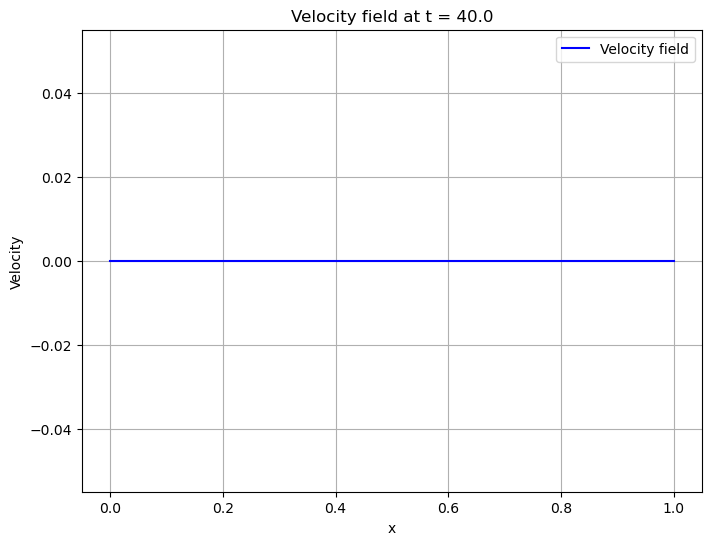

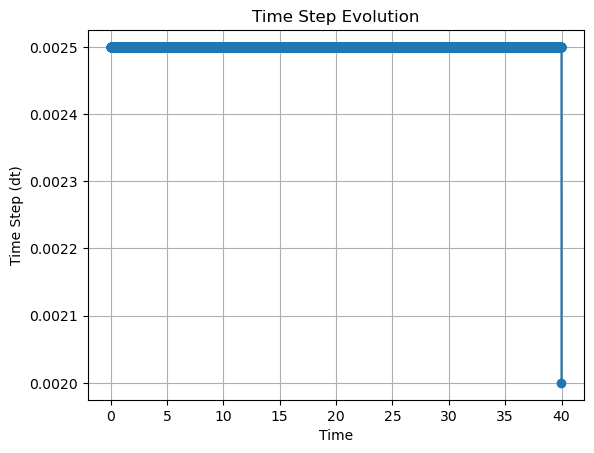

In [11]:
# Visualization
plt.figure(figsize=(8, 6))
plt.plot(x, u, color='b', label='Velocity field')
plt.xlabel('x')
plt.ylabel('Velocity')
plt.title(f'Velocity field at t = {ts[-1]}')
plt.grid(True)
plt.legend()
plt.show()

# Plot time step (dt) as a function of time (ts)
plt.plot(ts[:-1], np.diff(ts), marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Time Step (dt)')
plt.title('Time Step Evolution')
plt.grid(True)
plt.show()